**Comparing models performance to existing implementations**

- This is not trying to beat the other implementations. It's just to show that with converted model we are getting similar results.
- First is normal yolov3 with different sizes, then yolov3-tiny
- Performance is close enough to original implementation
  - Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.534
  - vs 55.3 in https://pjreddie.com/darknet/yolo/
- Differences come easily from better image processing etc
  - Training has happened with different processing than this notebooks evaluation
  - They probably resized so that object aspect ratio was kept same whereas we just resized (easier)
  - Also tuning confidence and nms thershold affect the value quite much
- This notebook requires
  - cocapi: https://github.com/cocodataset/cocoapi
  - the right datasets: http://cocodataset.org/#download

## Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
# use %autoreload command to reload all libraries

In [2]:
from IPython.core.debugger import set_trace
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"

In [3]:
# Python path fixing so we can import libraries
import sys
import os
sys_paths = ['../', # Adding yolov3_pytorch to python paths
            # '../../hands/fastai', # Fastai lib to help data handling etc: https://github.com/fastai/fastai
            '../../../data/coco/cocoapi/PythonAPI',
            ]
for p in sys_paths:
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

In [4]:
import time
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from matplotlib import patches, patheffects
import json
import pandas as pd

In [5]:
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.4.0


In [6]:
from yolov3_pytorch.utils import *
from yolov3_pytorch.yolov3 import *
from yolov3_pytorch.yolov3_tiny import *

In [7]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Codo Data Load and Examples

In [9]:
# anno_json = '../../../data/coco/annotations/image_info_test-dev2017.json'
anno_json = '../../../data/coco/annotations/instances_val2017.json'
img_path = '../../../data/coco/val2017'
with open(anno_json) as f:
    data = json.load(f)

In [10]:
data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [11]:
data['info']

{'contributor': 'COCO Consortium',
 'date_created': '2017/09/01',
 'description': 'COCO 2017 Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2017}

In [12]:
class_conversion = [(i, dic['id']) for i, dic in enumerate(data['categories'])]
class_conversion = dict(class_conversion)
class_conversion[0]
class_names = dict([(dic['id'], dic['name']) for i, dic in enumerate(data['categories'])])
class_names[1]

1

'person'

In [13]:
len(data['images'])
len(data['categories'])

5000

80

In [14]:
data['images'][0]

{'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'date_captured': '2013-11-14 17:02:52',
 'file_name': '000000397133.jpg',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'height': 427,
 'id': 397133,
 'license': 4,
 'width': 640}

In [15]:
data['categories'][0]
data['categories'][16]

{'id': 1, 'name': 'person', 'supercategory': 'person'}

{'id': 18, 'name': 'dog', 'supercategory': 'animal'}

In [16]:
pd_annotations = pd.DataFrame.from_dict(data['annotations'])

In [17]:
img_id = 37777
pd_annotations[pd_annotations['image_id']==img_id][:2]

,area,bbox,category_id,id,image_id,iscrowd,segmentation
31,88.52115,"[102.49, 118.47, 7.9, 17.31]",64,22328,37777,0,"[[110.39, 135.78, 110.39, 127.62, 110.01, 119...."
239,546.37500,"[26.5, 215.25, 61.5, 14.5]",62,100948,37777,0,"[[26.5, 229.25, 63.0, 215.25, 72.5, 215.25, 80..."


In [18]:
fnames = [d['file_name'] for d in data['images']]
fids = np.array([[d['id'], d['width'], d['height']] for d in data['images']])

In [19]:
fnames[:3]
fids[:3]

['000000397133.jpg', '000000037777.jpg', '000000252219.jpg']

array([[397133,    640,    427],
       [ 37777,    352,    230],
       [252219,    640,    428]])

# Load Model

In [20]:
model = Yolov3(num_classes=80)
model.load_state_dict(torch.load('../data/models/yolov3_coco_01.h5'))
_ = model.eval().cuda()

In [21]:
def img_fname(idx):
    return f"{img_path}/{idx:012d}.jpg"

**Checking that we get sensible predictions from data**

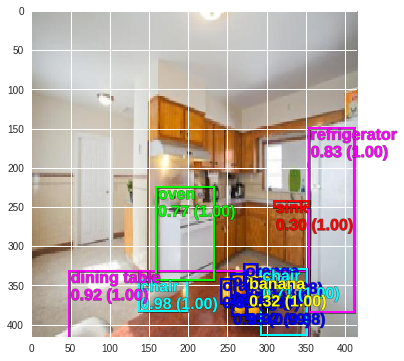

In [47]:
img_id = 37777
img_org = Image.open(img_fname(img_id)).convert('RGB')
img_tensor = image2torch(img_org.resize((416, 416))).cuda()
# For checking the results directly
_ = nms(model.predict_img(img_tensor)[0], .2)
plot_img_detections(img_tensor[0], _, figsize=(6, 6), class_names=list(class_names.values()))

# Predicting

In [23]:
def predict_all(data_imgs, sz=416, conf_thresh=.2, nms_thresh=.4):
    results = []
    img_ids = []
    for dat in tqdm(data_imgs):
        fname = dat['file_name']
        f_id = dat['id']
        img_ids.append(f_id)

        img = Image.open(img_fname(f_id)).convert('RGB')

        if sz:
            #img = img.resize((np.array(img), (sz, sz), interpolation=cv2.INTER_AREA)
            img = img.resize((sz, sz))

        img_torch = image2torch(img).cuda()
        all_boxes = model.predict_img(img_torch, conf_thresh=conf_thresh)[0]
        boxes = nms(all_boxes, nms_thresh=nms_thresh)

        width = dat['width']
        height = dat['height']

        for pred in boxes:
            box = np.array(pred[:4])
            box[:2] -= box[2:4]/2
            # box[2:4] = box[2:4]/2 + box[:2]
            x,w = box[0]*dat['width'], box[2]*dat['width']
            y,h = box[1]*dat['height'], box[3]*dat['height']
            cat = class_conversion[int(pred[-1])]
            res = {"image_id":f_id, "category_id":cat,
                    "bbox":[x, y, w, h], "score": pred[-2]}

            results.append(res)
    
    print(f"Results total {len(results)}. N of files {len(img_ids)}")
    return results, img_ids

In [24]:
# results, img_ids = predict_all(data['images'][0:max_len], conf_thresh=.25, nms_thresh=.2)
results, img_ids = predict_all(data['images'], conf_thresh=.2, nms_thresh=.4)

100%|██████████| 5000/5000 [01:55<00:00, 43.15it/s]
Results total 36503. N of files 5000


In [25]:
len(img_ids)
len(results)
results[0]

5000

36503

{'bbox': [378.3160352706909,
  78.52097272872925,
  140.90500831604004,
  270.7538112401962],
 'category_id': 1,
 'image_id': 397133,
 'score': 1.0}

In [26]:
#img_id = results[10]['image_id']
img_id = 37777
img_org = Image.open(img_fname(img_id)).convert('RGB')
img_boxes = []
img_classes = []
for r in results[0:1000]:
    if r['image_id'] == img_id:
        img_boxes.append(r['bbox'])
        img_classes.append(r['category_id'])

In [27]:
len(img_classes)
img_classes[0:10]
img_boxes[0]

12

[62, 55, 55, 67, 55, 55, 82, 79, 55, 62]

[115.85250425338745, 189.35831032693386, 51.92923450469971, 22.203272134065628]

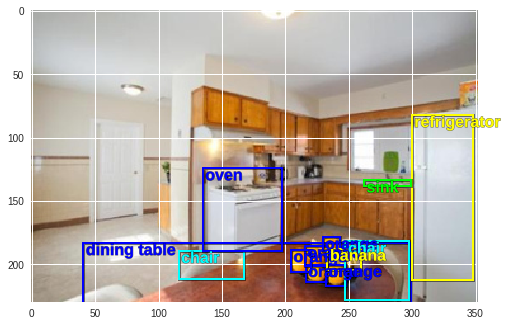

In [28]:
plot_img_boxes(img_org, img_boxes, img_classes, figsize=(8,8), real_pixels=True, box_centered=False,
               class_names=class_names)

# Cocotools Evaluation

In [29]:
cocoGt=COCO(anno_json)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [30]:
def coco_map_eval(results, img_ids, tmp_fname = '/tmp/coco_result_tmp_01.json'):
    print(f"With sample size {len(img_ids)}")
    with open(tmp_fname, 'wt') as outfile:
        json.dump(results, outfile)
        
    cocoDt=cocoGt.loadRes(tmp_fname)
        
    cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
    cocoEval.params.imgIds  = img_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

In [31]:
len(results)

36503

In [32]:
results[:3]

[{'bbox': [378.3160352706909,
   78.52097272872925,
   140.90500831604004,
   270.7538112401962],
  'category_id': 1,
  'image_id': 397133,
  'score': 1.0},
 {'bbox': [53.518667221069336,
   288.0378689020872,
   81.85909271240234,
   39.44082072377205],
  'category_id': 51,
  'image_id': 397133,
  'score': 0.9999895095825195},
 {'bbox': [142.98033833503723,
   268.2764089629054,
   28.47980260848999,
   34.132702842354774],
  'category_id': 47,
  'image_id': 397133,
  'score': 0.9997795224189758}]

In [33]:
coco_map_eval(results, img_ids)

With sample size 5000
Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.37s).
Accumulating evaluation results...
DONE (t=1.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

# Yolov3 608

In [44]:
model = Yolov3(num_classes=80)
model.load_state_dict(torch.load('../data/models/yolov3_coco_01.h5'))
_ = model.eval().cuda()

In [45]:
results, img_ids = predict_all(data['images'], conf_thresh=.2, nms_thresh=.4, sz=608)

100%|██████████| 5000/5000 [02:49<00:00, 29.53it/s]
Results total 38661. N of files 5000


In [46]:
coco_map_eval(results, img_ids)

With sample size 5000
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.26s).
Accumulating evaluation results...
DONE (t=1.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.389
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.399
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

# Yolov3 Tiny

In [39]:
model = Yolov3Tiny(num_classes=80, use_wrong_previous_anchors=True)
model.load_state_dict(torch.load('../data/models/yolov3_tiny_coco_01.h5'))
_ = model.eval().cuda()

In [42]:
# results, img_ids = predict_all(data['images'][0:max_len], conf_thresh=.25, nms_thresh=.2)
results, img_ids = predict_all(data['images'], conf_thresh=.1, nms_thresh=.3)

100%|██████████| 5000/5000 [00:54<00:00, 92.47it/s]
Results total 30769. N of files 5000


In [43]:
coco_map_eval(results, img_ids)

With sample size 5000
Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.98s).
Accumulating evaluation results...
DONE (t=1.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.199
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar